# Fall Pervention - Data Analysis

>[Fall Pervention - Data Analysis](#scrollTo=-xh1Of4lk5V2)

>>[Getting Ready](#scrollTo=o8w5Kah4lic6)

>>>>[Importing the libraries](#scrollTo=wzlEwGQKk5m0)

>>>>[Uploading the ZIP file containing the patients data dirs:](#scrollTo=ehouBttelr-f)

>>>>[Extracting the ZIP file into ./data/](#scrollTo=uLDiWW7ZmAxp)

>>>>[Creating our Dataset using all patients data:](#scrollTo=RZWl3rQUmPXV)

>>[Data Exploration](#scrollTo=EPiOmgwip-4v)

>>>>[Splitting the Dataset](#scrollTo=T7PpCtlYpkZy)

>>>>[Data Pre-Processing Pipeline](#scrollTo=QBWfkXz3prUi)

>>>>[Boxplots of the sensors:](#scrollTo=txZ71RyyqJbx)

>>>>[Jointplots of conflicting positions](#scrollTo=9m7SBaCnrUxB)

>>>>[Separating the labels from the data](#scrollTo=ERO0JOWxuSQ3)

>>[Everyday I'm Modeling](#scrollTo=xNac6hGA8YsD)

>>>[First Take](#scrollTo=cnCP3rDjI01N)

>>>>[Convolutional Neural Network](#scrollTo=eqtJcGCF8Y-b)

>>>>[Recurrent Neural Network](#scrollTo=gsKIxcXr8udO)

>>>>[Random Forest](#scrollTo=veCRuGrz8yGb)

>>>[Second Take](#scrollTo=bdyx44AkJAAx)

>>>>[Convolutional Neural Network](#scrollTo=mrMTE3pcKXzn)

>>>>[Recurrent Neural Network](#scrollTo=BrpSWHmDKui4)

>>>>[Random Forest](#scrollTo=mDXAInSDKvg_)



## Getting Ready

#### Importing the libraries
We'll use Matplotlib, Seaborn for our charts, Numpy, Pandas for the data and calculations, and Tensorflor/keras for the Neural Networks:

In [1]:
from google.colab import files

import zipfile
import random
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

from keras.layers import Conv1D, BatchNormalization, Dense, Flatten, Input, LSTM, Dropout
from keras.models import Sequential
import tensorflow as tf
import torch
import keras

#### Uploading the ZIP file containing the patients data dirs:

In [2]:
uploadedData = files.upload()

Saving data.zip to data.zip


#### Extracting the ZIP file into ./data/

In [3]:
filename = list(uploadedData)[0]
data_dir = "data/"

try:
    os.rmdir(data_dir)
except FileNotFoundError:
    pass

os.mkdir(data_dir)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

#### Creating our Dataset using all patients data:

For each patient dir and for each csv file in the dir, make one dataset containing all of the file's content

In [32]:
def create_dataset(data_dir: str, rand: bool = False) -> pd.DataFrame:
    files_content_list = []
    
    # For each Patient dir
    for dir in os.listdir(data_dir):
        if os.path.isfile(os.path.join(data_dir, dir)):
            continue

        # For each data file
        for file in os.listdir(os.path.join(data_dir, dir)):
            if not os.path.isfile(os.path.join(data_dir, dir, file)):
                continue

            file_content = pd.read_csv(os.path.join(data_dir, dir, file))
            files_content_list.append(file_content)
        
    if rand:
        random.shuffle(files_content_list)

    return pd.concat(files_content_list, axis=0, ignore_index=True)

In [38]:
dataset = create_dataset(data_dir)

## Data Exploration

Let's look at our data samples:

In [39]:
print(dataset.shape)
print(dataset.head())

(6400, 12)
   Unnamed: 0  FFSR1  FFSR2  FFSR3  FFSR4  RFSR1  RFSR2  RFSR3  RFSR4  Weight  \
0           0      0   3517   2915      0      0    809    398    511      79   
1           1      0   3555   3082      0      0    838    320    498      79   
2           2      0   3544   3181      0      0    835    352    507      79   
3           3      0   3543   3095      0      0    835    373    520      79   
4           4      0   3546   3120      0      0    837    376    522      79   

   Height  Label  
0     176      1  
1     176      1  
2     176      1  
3     176      1  
4     176      1  


We can see that our data sampled equally among the labels:

In [40]:
print(dataset.Label.value_counts())

1    1280
0    1280
3    1280
2    1280
4    1280
Name: Label, dtype: int64


#### Splitting the Dataset

We will use 80% of the dataset for training, and 20% for testing.
We will NOT use shuffle, as we want to test "new" patients.

In [36]:
random_state = 0
test_size = 0.2

train, test = train_test_split(dataset, test_size=test_size, shuffle=False)

print(train.shape, test.shape)

(5120, 12) (1280, 12)


#### Data Pre-Processing Pipeline

Simple Pre-processing:
We will remove the ID, Weight and Height columns.
Also, We will use Standard Scaler to normalize all of the features.

In [42]:
class data_preparation():

  def __init__(self, training_data, new_data):
    self.new_dataset = new_data.copy()
    self.training_data_ref = training_data.copy()

    self.__remove_ids(self.training_data_ref)

  def __remove_ids(self, dataset):
      dataset.drop(columns=dataset.columns[0], axis=1,  inplace=True)
      dataset.drop("Weight", axis=1,  inplace=True)
      dataset.drop("Height", axis=1,  inplace=True)
      

  def __normalize(self):
    all_features = list(self.training_data_ref.columns)
    all_features.remove('Label')

    
    for feature in all_features:
        std_scaler = StandardScaler()
        std_scaler.fit(self.training_data_ref[[feature]])

        self.new_dataset[[feature]] = std_scaler.transform(self.new_dataset[[feature]])
    
    return self.new_dataset


  def prepare(self):
    self.__remove_ids(self.new_dataset)
    self.__normalize()

    return self.new_dataset

def preprare_data(training_data, new_data):
  data_prep = data_preparation(training_data, new_data)
  return data_prep.prepare()


Our data after the pre-processing:

In [41]:
prep_train = preprare_data(train, train)
prep_test = preprare_data(train, test)

print(prep_train.shape, prep_test.shape)
prep_train.head()

(5120, 9) (1280, 9)


,FFSR1,FFSR2,FFSR3,FFSR4,RFSR1,RFSR2,RFSR3,RFSR4,Label
0,-0.754599,1.407616,1.051460,-0.756259,-0.629833,1.673647,-0.196143,-0.088734,1
1,-0.754599,1.432207,1.162363,-0.756259,-0.629833,1.768226,-0.455320,-0.139095,1
2,-0.754599,1.425089,1.228107,-0.756259,-0.629833,1.758442,-0.348991,-0.104230,1
3,-0.754599,1.424442,1.170996,-0.756259,-0.629833,1.758442,-0.279212,-0.053869,1
4,-0.754599,1.426383,1.187598,-0.756259,-0.629833,1.764965,-0.269244,-0.046121,1


#### Boxplots of the sensors:

In [10]:
def get_boxplots(data: pd.DataFrame) -> None:
    f, pl = plt.subplots(3, 2, figsize=(25, 15))

    all_features = list(data.columns)
    all_features.remove('Label')

    tmpdf0 = data[data.Label == 0]
    tmpdf1 = data[data.Label == 1]
    tmpdf2 = data[data.Label == 2]
    tmpdf3 = data[data.Label == 3]
    tmpdf4 = data[data.Label == 4]


    sns.boxplot(ax = pl[0][0], data=tmpdf0.loc[:,all_features])
    sns.boxplot(ax = pl[0][1], data=tmpdf1.loc[:,all_features])
    sns.boxplot(ax = pl[1][0], data=tmpdf2.loc[:,all_features])
    sns.boxplot(ax = pl[1][1], data=tmpdf3.loc[:,all_features])
    sns.boxplot(ax = pl[2][0], data=tmpdf4.loc[:,all_features])

    pl[0][0].set_title("Sensors values - Laying Center")
    pl[0][1].set_title("Sensors values - Laying Left")
    pl[1][0].set_title("Sensors values - Laying Right")
    pl[1][1].set_title("Sensors values - Alarm Left")
    pl[2][0].set_title("Sensors values - Alarm Right")

    f.tight_layout(pad=5.0)

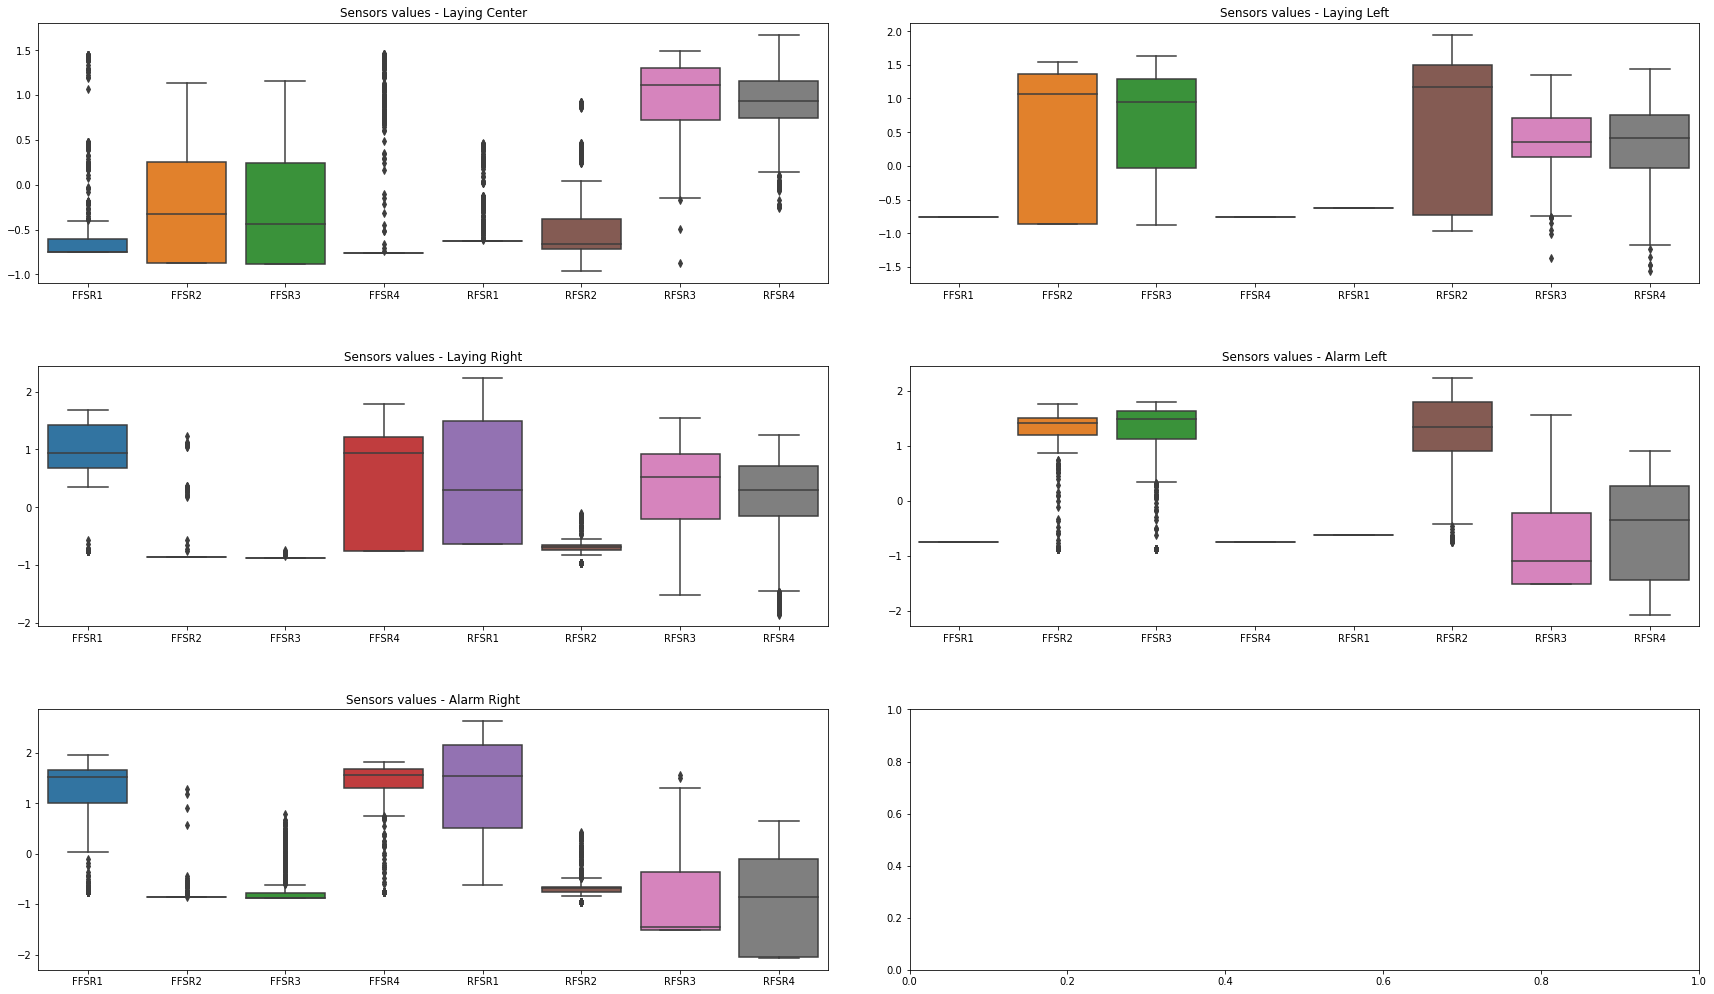

In [11]:
get_boxplots(prep_train)

We can see that the sensors give unique values for each label (position) in average, thing that will help us later. 

#### Jointplots of conflicting positions

Text(0.5, 0.98, 'Left vs. Left Alarm')

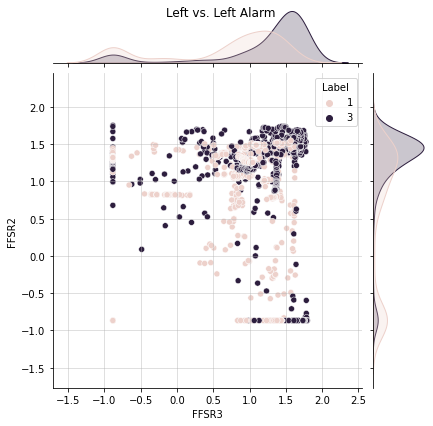

In [43]:
sns.color_palette("colorblind")
g = sns.jointplot(x="FFSR3", y="FFSR2", data=prep_train[(prep_train.Label == 1) | (prep_train.Label == 3)], hue='Label')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("Left vs. Left Alarm")

Text(0.5, 0.98, 'Right vs. Right Alarm')

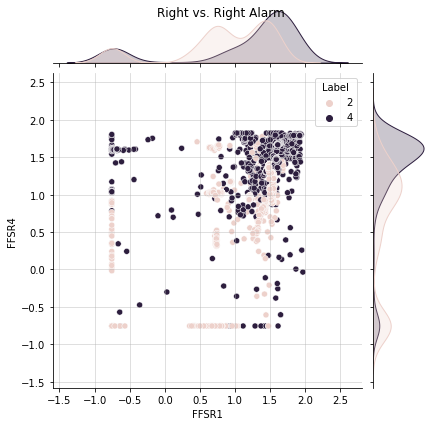

In [44]:
g = sns.jointplot(x="FFSR1", y="FFSR4", data=prep_train[(prep_train.Label == 2) | (prep_train.Label == 4)], hue='Label')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("Right vs. Right Alarm")

Here we also can see unique values in the sensors that located on the sides of the bed. 

#### Separating the labels from the data

For Non-Sequential models:

In [45]:
all_features = list(prep_train.columns)
all_features.remove('Label')

X_train = prep_train.loc[:,all_features]
y_train = prep_train["Label"]

X_test = prep_test.loc[:,all_features]
y_test = prep_test["Label"]

For Sequential models:

In [46]:
SEQ_LEN = 4

def get_time_series_df(X, y, length = SEQ_LEN):
    ts_X, ts_y = [], []
    for l in range(0, len(X) - length, length):
        ts_X.append(X[l:l + length])
        ts_y.append(y[l])

    return np.array(ts_X), np.array(ts_y)

In [48]:
X_train_sequence, y_train_sequence = get_time_series_df(prep_train.loc[:,all_features].values, prep_train.Label.values)
X_test_sequence, y_test_sequence = get_time_series_df(prep_test.loc[:,all_features].values, prep_test.Label.values)

## Everyday I'm Modeling

### First Take

#### Convolutional Neural Network

In [19]:
model = Sequential()
model.add(Input((SEQ_LEN, len(all_features), )))
model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(5))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()

High level diagram of the network:

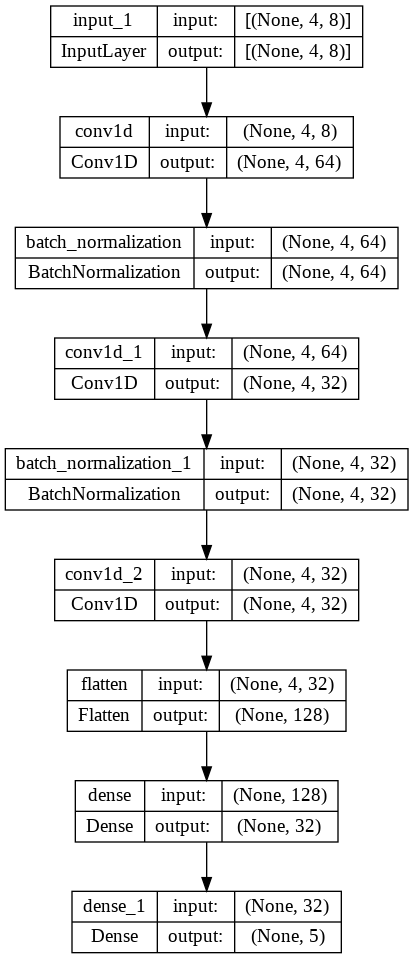

In [20]:
keras.utils.plot_model(model, show_shapes=True)

Let's train our CNN:

In [21]:
model.fit(X_train_sequence, y_train_sequence, batch_size=8, epochs=32)

Epoch 1/32
160/160 [==============================] - 4s 5ms/step - loss: 0.6777 - accuracy: 0.7357
Epoch 2/32
160/160 [==============================] - 1s 4ms/step - loss: 0.4609 - accuracy: 0.8116
Epoch 3/32
160/160 [==============================] - 1s 5ms/step - loss: 0.3674 - accuracy: 0.8514
Epoch 4/32
160/160 [==============================] - 1s 7ms/step - loss: 0.3302 - accuracy: 0.8624
Epoch 5/32
160/160 [==============================] - 1s 6ms/step - loss: 0.2901 - accuracy: 0.8913
Epoch 6/32
160/160 [==============================] - 1s 8ms/step - loss: 0.2484 - accuracy: 0.9007
Epoch 7/32
160/160 [==============================] - 1s 6ms/step - loss: 0.2423 - accuracy: 0.9085
Epoch 8/32
160/160 [==============================] - 1s 5ms/step - loss: 0.2128 - accuracy: 0.9195
Epoch 9/32
160/160 [==============================] - 1s 4ms/step - loss: 0.2450 - accuracy: 0.9109
Epoch 10/32
160/160 [==============================] - 1s 6ms/step - loss: 0.1980 - accuracy: 0.9257

In [49]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

10/10 [==============================] - 0s 2ms/step
Train Accuracy: 98.0%, Test Accuracy: 71.8%


Not good enough!
Surprisingly, we have got relatively poor Test Accuracy.

Let's see where the model was wrong:

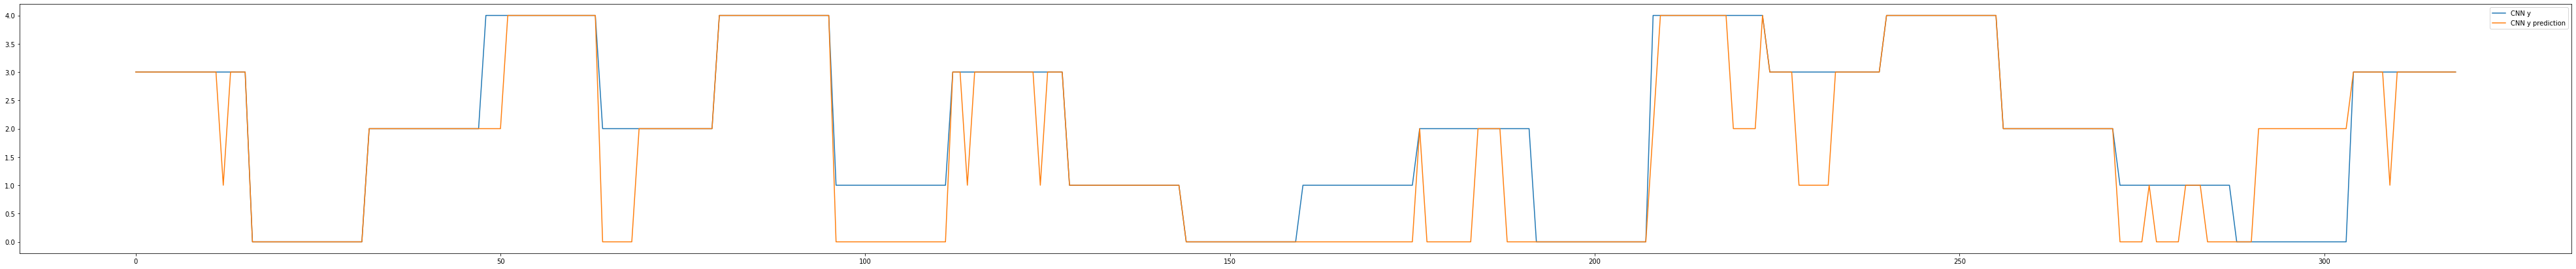

In [51]:
ds = pd.DataFrame()

ds["CNN y"] = y_test_sequence
ds["CNN y prediction"] = y_test_pred

ds.plot(figsize=(70, 7))

From the data exploration above, it can be seen that the sensors gives close values for the positions: Back, Left and Right laying (Without alert).
Let's try to "merge" them into one label:

In [52]:
a,b,c,d,e,f = 0,0,0,0,0,0
for i in range(len(y_test_pred)):
    if y_test_sequence[i] == 3:
        if y_test_pred[i] == 3:
            a += 1
        b += 1

    if y_test_sequence[i] == 4:
        if y_test_pred[i] == 4:
            c += 1
        d += 1

    if y_test_sequence[i] in [0,1,2]:
        if y_test_pred[i] in [0,1,2]:
            e += 1
        f += 1
        
print(a/b, c/d, e/f)

0.8571428571428571 0.875 1.0


Amazing Results!

#### Recurrent Neural Network

In [53]:
model = Sequential()
model.add(LSTM(units=32, input_shape=(SEQ_LEN, len(all_features)), activation="relu"))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

Let's train our LSTM RNN:

In [54]:
model.fit(X_train_sequence, y_train_sequence, batch_size=8, epochs=32)

Epoch 1/32


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


160/160 [==============================] - 2s 4ms/step - loss: 1.0560 - accuracy: 0.6036
Epoch 2/32
160/160 [==============================] - 1s 4ms/step - loss: 0.5851 - accuracy: 0.7756
Epoch 3/32
160/160 [==============================] - 1s 6ms/step - loss: 0.5057 - accuracy: 0.8045
Epoch 4/32
160/160 [==============================] - 1s 6ms/step - loss: 0.4315 - accuracy: 0.8319
Epoch 5/32
160/160 [==============================] - 1s 9ms/step - loss: 0.3648 - accuracy: 0.8499
Epoch 6/32
160/160 [==============================] - 1s 7ms/step - loss: 0.3328 - accuracy: 0.8608
Epoch 7/32
160/160 [==============================] - 1s 5ms/step - loss: 0.2929 - accuracy: 0.8921
Epoch 8/32
160/160 [==============================] - 1s 6ms/step - loss: 0.2664 - accuracy: 0.9015
Epoch 9/32
160/160 [==============================] - 1s 5ms/step - loss: 0.2401 - accuracy: 0.9085
Epoch 10/32
160/160 [==============================] - 1s 5ms/step - loss: 0.2184 - accuracy: 0.9203
Epoch 11/3

Let's test out RNN:

In [55]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

10/10 [==============================] - 0s 2ms/step
Train Accuracy: 96.0%, Test Accuracy: 78.7%


Slightly better than the CNN. but still - could be better...

#### Random Forest

Let's try Random Forest too, as an eample of non sequential model:

In [29]:
h = RandomForestClassifier(n_estimators=100, max_leaf_nodes=12)
h.fit(X_train, y_train)

trainAcc = np.sum(h.predict(X_train) == y_train) * 100 / len(y_train)
testAcc = np.sum(h.predict(X_test) == y_test) * 100 / len(y_test)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Train Accuracy: 92.3%, Test Accuracy: 75.6%


Same problem as the above models... need new approach!

### Second Take

Lets use the conclusion from the First Take of the modeling, and merge the non-alarm labels:

In [56]:
class data_preparation():

  def __init__(self, training_data, new_data):
    self.new_dataset = new_data.copy()
    self.training_data_ref = training_data.copy()

    self.__remove_ids(self.training_data_ref)
    self.__merge_labels(self.training_data_ref)

  def __merge_labels(self, dataset):
      dataset.loc[dataset['Label'] == 0, 'Label'] = 0
      dataset.loc[dataset['Label'] == 1, 'Label'] = 0
      dataset.loc[dataset['Label'] == 2, 'Label'] = 0
      dataset.loc[dataset['Label'] == 3, 'Label'] = 1
      dataset.loc[dataset['Label'] == 4, 'Label'] = 2

  def __remove_ids(self, dataset):
      dataset.drop(columns=dataset.columns[0], axis=1,  inplace=True)
      dataset.drop("Weight", axis=1,  inplace=True)
      dataset.drop("Height", axis=1,  inplace=True)
      

  def __normalize(self):
    all_features = list(self.training_data_ref.columns)
    all_features.remove('Label')

    
    for feature in all_features:
        std_scaler = StandardScaler()
        std_scaler.fit(self.training_data_ref[[feature]])

        self.new_dataset[[feature]] = std_scaler.transform(self.new_dataset[[feature]])
    
    return self.new_dataset


  def prepare(self):
    self.__merge_labels(self.new_dataset)
    self.__remove_ids(self.new_dataset)
    self.__normalize()

    return self.new_dataset

def preprare_data(training_data, new_data):
  data_prep = data_preparation(training_data, new_data)
  return data_prep.prepare()

In [57]:
prep_train = preprare_data(train, train)
prep_test = preprare_data(train, test)

all_features = list(prep_train.columns)
all_features.remove('Label')

X_train = prep_train.loc[:,all_features]
y_train = prep_train["Label"]

X_test = prep_test.loc[:,all_features]
y_test = prep_test["Label"]

X_train_sequence, y_train_sequence = get_time_series_df(prep_train.loc[:,all_features].values, prep_train.Label.values)
X_test_sequence, y_test_sequence = get_time_series_df(prep_test.loc[:,all_features].values, prep_test.Label.values)

#### Convolutional Neural Network

In [87]:
model = Sequential()
model.add(Input((SEQ_LEN, len(all_features), )))
model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()
model.fit(X_train_sequence, y_train_sequence, batch_size=8, epochs=24)

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Epoch 1/24
160/160 [==============================] - 2s 4ms/step - loss: 0.3746 - accuracy: 0.8507
Epoch 2/24
160/160 [==============================] - 1s 8ms/step - loss: 0.2727 - accuracy: 0.8882
Epoch 3/24
160/160 [==============================] - 1s 8ms/step - loss: 0.2275 - accuracy: 0.9101
Epoch 4/24
160/160 [==============================] - 1s 9ms/step - loss: 0.2148 - accuracy: 0.9203
Epoch 5/24
160/160 [==============================] - 1s 7ms/step - loss: 0.2068 - accuracy: 0.9179
Epoch 6/24
160/160 [==============================] - 1s 3ms/step - loss: 0.1907 - accuracy: 0.9265
Epoch 7/24
160/160 [==============================] - 1s 3ms/step - loss: 0.1687 - accuracy: 0.9351
Epoch 8/24
160/160 [==============================] - 1s 3ms/step - loss: 0.1666 - accuracy: 0.9304
Epoch 9/24
160/160 [==============================] - 1s 4ms/step - loss: 0.1585 - accuracy: 0.9421
Epoch 10/24
160/160 [==============================] - 1s 4ms/step - loss: 0.1415 - accuracy: 0.9461

#### Recurrent Neural Network

In [63]:
model = Sequential()
model.add(LSTM(units=32, input_shape=(SEQ_LEN, len(all_features)), activation="relu"))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()
model.fit(X_train_sequence, y_train_sequence, batch_size=8, epochs=32)

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Epoch 1/32


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


160/160 [==============================] - 2s 4ms/step - loss: 0.5767 - accuracy: 0.8069
Epoch 2/32
160/160 [==============================] - 1s 4ms/step - loss: 0.3060 - accuracy: 0.8866
Epoch 3/32
160/160 [==============================] - 1s 4ms/step - loss: 0.2440 - accuracy: 0.9124
Epoch 4/32
160/160 [==============================] - 1s 4ms/step - loss: 0.2199 - accuracy: 0.9187
Epoch 5/32
160/160 [==============================] - 1s 4ms/step - loss: 0.1988 - accuracy: 0.9124
Epoch 6/32
160/160 [==============================] - 1s 4ms/step - loss: 0.2033 - accuracy: 0.9156
Epoch 7/32
160/160 [==============================] - 1s 4ms/step - loss: 0.1780 - accuracy: 0.9187
Epoch 8/32
160/160 [==============================] - 1s 4ms/step - loss: 0.1723 - accuracy: 0.9218
Epoch 9/32
160/160 [==============================] - 1s 4ms/step - loss: 0.1555 - accuracy: 0.9382
Epoch 10/32
160/160 [==============================] - 1s 4ms/step - loss: 0.1544 - accuracy: 0.9335
Epoch 11/3

#### Random Forest

In [66]:
h = RandomForestClassifier(n_estimators=100, max_leaf_nodes=12)
h.fit(X_train, y_train)

trainAcc = np.sum(h.predict(X_train) == y_train) * 100 / len(y_train)
testAcc = np.sum(h.predict(X_test) == y_test) * 100 / len(y_test)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Train Accuracy: 94.6%, Test Accuracy: 96.2%


### Conclusion
Let's compare the results:
<br>
CNN:
Train Accuracy: 95.8%, Test Accuracy: 96.9%

RNN:
Train Accuracy: 98.4%, Test Accuracy: 96.6%

RF:
Train Accuracy: 94.6%, Test Accuracy: 96.2%
<br>
As we suspected, the CNN gives the best predictions!

## Store the Model

In [102]:
model = Sequential()
model.add(Input((SEQ_LEN, len(all_features), )))
model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()
model.fit(X_train_sequence, y_train_sequence, batch_size=8, epochs=24)

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Epoch 1/24
160/160 [==============================] - 3s 6ms/step - loss: 0.4318 - accuracy: 0.8327
Epoch 2/24
160/160 [==============================] - 1s 3ms/step - loss: 0.2855 - accuracy: 0.8898
Epoch 3/24
160/160 [==============================] - 1s 3ms/step - loss: 0.2194 - accuracy: 0.9101
Epoch 4/24
160/160 [==============================] - 1s 3ms/step - loss: 0.2070 - accuracy: 0.9085
Epoch 5/24
160/160 [==============================] - 1s 3ms/step - loss: 0.1884 - accuracy: 0.9148
Epoch 6/24
160/160 [==============================] - 1s 3ms/step - loss: 0.1771 - accuracy: 0.9234
Epoch 7/24
160/160 [==============================] - 1s 3ms/step - loss: 0.1846 - accuracy: 0.9273
Epoch 8/24
160/160 [==============================] - 1s 3ms/step - loss: 0.1475 - accuracy: 0.9445
Epoch 9/24
160/160 [==============================] - 1s 3ms/step - loss: 0.1518 - accuracy: 0.9398
Epoch 10/24
160/160 [==============================] - 1s 3ms/step - loss: 0.1405 - accuracy: 0.9461

In [103]:
model.save("fp_model.h5")

Download the model:

In [104]:
files.download('fp_model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Little sanity check:

In [105]:
uploadedData = files.upload()
model_name = list(uploadedData)[0]

loaded_model = tf.keras.models.load_model(model_name)

Saving fp_model.h5 to fp_model (3).h5


In [106]:
probability_model = tf.keras.Sequential([loaded_model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

10/10 [==============================] - 0s 2ms/step
Train Accuracy: 98.4%, Test Accuracy: 93.7%


Perfect!